In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Importin data 

In [2]:
# Read the tsv file and store as Dataframe
data = pd.read_csv('data.tsv', sep='\t')
data

,Treatment,Concentration,Replicate,alpha,beta,delta
0,A,one,1,57.536912,24.038580,0.638744
1,A,one,2,77.242173,23.233112,0.502943
2,A,one,3,78.320886,31.646452,0.466701
3,A,two,1,48.680961,17.756076,0.424798
4,A,two,2,43.871396,7.607038,0.248512
...,...,...,...,...,...,...
94,K,two,2,163.440673,35.243690,1.000000
95,K,two,3,21.916488,56.964298,1.000000
96,K,three,1,88.991740,38.036808,0.900000
97,K,three,2,64.223970,38.570164,0.900000


# Basic stats 

In [3]:
data.head()

,Treatment,Concentration,Replicate,alpha,beta,delta
0,A,one,1,57.536912,24.038580,0.638744
1,A,one,2,77.242173,23.233112,0.502943
2,A,one,3,78.320886,31.646452,0.466701
3,A,two,1,48.680961,17.756076,0.424798
4,A,two,2,43.871396,7.607038,0.248512


In [4]:
# Get basic information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Treatment      99 non-null     object 
 1   Concentration  99 non-null     object 
 2   Replicate      99 non-null     int64  
 3   alpha          99 non-null     float64
 4   beta           99 non-null     float64
 5   delta          99 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.8+ KB


In [5]:
# Unique treatments used in the data
cols = data['Treatment'].unique()
cols

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'],
      dtype=object)

In [6]:
# Basic correlation comparing the columns in the dataset
data.corr()

,Replicate,alpha,beta,delta
Replicate,1.000000,-0.103723,-0.029500,0.090336
alpha,-0.103723,1.000000,0.341312,0.301593
beta,-0.029500,0.341312,1.000000,0.326343
delta,0.090336,0.301593,0.326343,1.000000


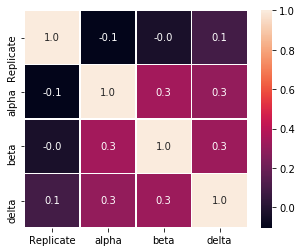

In [7]:
#Plotting the basic correlation map
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [8]:
# Get basic stats of each column in the dataset
data.describe()

,Replicate,alpha,beta,delta
count,99.000000,99.000000,99.000000,99.000000
mean,2.000000,53.969234,27.994312,0.671608
std,0.820652,28.232502,12.522977,0.251292
min,1.000000,17.117738,-1.930139,0.158446
25%,1.000000,36.422774,18.787162,0.497748
50%,2.000000,48.601313,27.788739,0.647937
75%,3.000000,66.000924,36.759370,0.840746
max,3.000000,189.181118,63.775903,1.323492


# Reformating and ANOVA/Tukey's HSD

## Reform. for ANOVA 

In [9]:
# # Creates a new df using only the data having used concentraion 1 
# conc1 = data.loc[data.Concentration == 'Low']
# conc1

In [10]:
# # Reformats the df by separating each treatment into its own column while also keeping the conditions separate. 
# # Then adds the treatment name to the title of each of the three respective columns using that treatment
# conc1_reformat = pd.DataFrame()
# for i in cols:
#     df1 = conc1.loc[data.Treatment == i]

#     df1 = df1.rename(columns={'TNF_alpha':i + ' TNF_alpha', 'IL_6':i + ' IL-6', 'NF_kB':i + ' NF_kB'}).reset_index()
#     conc1_reformat = pd.concat([conc1_reformat, df1],axis=1)

# conc1_reformat

In [11]:
# # Eliminates the uneccessary columns after the reformat
# conc1_reformat = conc1_reformat.drop(['index','Treatment','Concentration','Replicate'], axis=1)
# conc1_reformat

In [12]:
# # Appends the Concentration to the title of each column
# conc1_reformat.columns = ['Low ' + col for col in conc1_reformat.columns]
# conc1_reformat

In [22]:
# Method that reformats the df to have each column represent a single sample (including concentration, treatments, and condition combinations)
# Input is the dataframe, and Concentration ('one','two','three')
def reformat_concentration_data(data, concentration_level='one', treatment_columns=None):
    # Creates a new df using only the data with the specified concentration level
    conc_data = data.loc[data.Concentration == concentration_level]
    
    # If no treatment columns are provided, default to an empty list (which will result in no specific treatment filtering)
    if treatment_columns is None:
        treatment_columns = conc_data['Treatment'].unique()
    
    # Empty df for storing reformated data
    conc_reformat = pd.DataFrame()
    
    for treatment in treatment_columns:
        treatment_data = conc_data.loc[conc_data.Treatment == treatment]
        
        # Rename columns to append treatment name to each relevant column
        treatment_data = treatment_data.rename(columns={
            'alpha': f'{treatment} alpha',
            'beta': f'{treatment} beta',
            'delta': f'{treatment} delta'
        }).reset_index(drop=True)
        
        # Concatenate the treatment-specific data to the reformatted dataframe
        conc_reformat = pd.concat([conc_reformat, treatment_data], axis=1)
    
    # Eliminate unnecessary columns after the reformat
    conc_reformat = conc_reformat.drop(['index', 'Treatment', 'Concentration', 'Replicate'], axis=1, errors='ignore')
    
    # Add the concentration prefix to each column name
    conc_reformat.columns = [concentration_level + ' ' + col for col in conc_reformat.columns]
    
    return conc_reformat

In [24]:
# Generated a df for each Concentration
reformatted_conc1 = reformat_concentration_data(data, concentration_level='one')
reformatted_conc2 = reformat_concentration_data(data, concentration_level='two')
reformatted_conc3 = reformat_concentration_data(data, concentration_level='three')
reformatted_conc3

,three A alpha,three A beta,three A delta,three B alpha,three B beta,three B delta,three C alpha,three C beta,three C delta,three D alpha,...,three H delta,three I alpha,three I beta,three I delta,three J alpha,three J beta,three J delta,three K alpha,three K beta,three K delta
0,20.377292,8.891099,0.625672,22.785994,14.220423,0.574197,39.426783,36.517149,0.158446,36.246606,...,1.323492,74.303105,29.071352,0.265474,39.047594,-1.930139,0.445610,88.991740,38.036808,0.9
1,29.110063,17.178158,0.261482,36.398314,6.926975,0.481835,53.150440,24.696377,0.576179,34.516568,...,0.801720,42.983269,18.705708,0.783438,35.958910,14.017735,0.923834,64.223970,38.570164,0.9
2,25.031901,17.421167,0.295975,27.070947,13.009237,0.518071,41.468172,8.099449,0.590459,46.464814,...,0.766614,27.319668,23.082108,0.720898,17.117738,20.479644,0.653533,91.424496,36.913446,0.9


## ANOVA

In [25]:
# Assuming data is normal, has equal variance, and independent
# Function to perform one-way ANOVA on each column
def run_anova_on_dataframe(df):
    # Collect the columns into a list of series
    groups = [df[col] for col in df.columns]
    
    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*groups)
    
    return f_statistic, p_value

In [26]:
# ANOVA on Concentration 1
f_stat, p_value = run_anova_on_dataframe(reformatted_conc1)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

F-statistic: 21.28223845844893, P-value: 4.784185861966556e-24


In [27]:
# ANOVA on Concentration 2
f_stat, p_value = run_anova_on_dataframe(reformatted_conc2)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

F-statistic: 6.150730322949344, P-value: 2.626114068332527e-10


In [28]:
# ANOVA on Concentration 3
f_stat, p_value = run_anova_on_dataframe(reformatted_conc3)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

F-statistic: 19.43758265114199, P-value: 6.411458455595027e-23


## Reform. for Tukey's 

In [29]:
# Creates a df that contains only one of the conditions named as "value_column".
# Replicates are maintained on each row.
# Each column is an individual Treatment-Concentration combination of the same conditoin named in the method.
# Condition is saved in the df title
def reformat_treatment_data(data, cols=None, value_column='alpha'):
    # Initialize an empty DataFrame for the final result
    df = pd.DataFrame()

    # If no cols are provided, use the unique treatments in the data
    if cols is None:
        cols = data['Treatment'].unique()

    for i in cols:
        # Filter data for each treatment
        df1 = data.loc[data.Treatment == i]

        # Filter data by Concentration
        df2 = df1.loc[df1.Concentration == 'one']
        df3 = df1.loc[df1.Concentration == 'two']
        df4 = df1.loc[df1.Concentration == 'three']
        
        # Create new DataFrames for each concentration with renamed columns using the specified value column
        new_one = pd.DataFrame(df2[value_column]).rename(columns={value_column: f'{i} one'}).reset_index(drop=True)
        new_two = pd.DataFrame(df3[value_column]).rename(columns={value_column: f'{i} two'}).reset_index(drop=True)
        new_three = pd.DataFrame(df4[value_column]).rename(columns={value_column: f'{i} three'}).reset_index(drop=True)

        # Concatenate the data for the current treatment across the three concentrations
        treatment = pd.concat([new_one, new_two, new_three], axis=1)
        
        # Append the current treatment data to the final DataFrame
        df = pd.concat([df, treatment], axis=1)

    # Drop the 'index' column if it exists
    df = df.drop('index', axis=1, errors='ignore')
    
    return df

In [30]:
# Create a df for each condition for running a Tukey's HSD test
condition_alpha = reformat_treatment_data(data,value_column='alpha')
condition_beta = reformat_treatment_data(data,value_column='beta')
condition_delta = reformat_treatment_data(data,value_column='delta')
condition_delta

,A one,A two,A three,B one,B two,B three,C one,C two,C three,D one,...,H three,I one,I two,I three,J one,J two,J three,K one,K two,K three
0,0.638744,0.424798,0.625672,0.494079,0.304054,0.574197,0.585372,0.971248,0.158446,0.655981,...,1.323492,0.663220,0.484451,0.265474,0.69641,0.396126,0.445610,1.1,1.0,0.9
1,0.502943,0.248512,0.261482,0.536921,0.513992,0.481835,0.984620,0.772327,0.576179,0.971388,...,0.801720,0.359202,0.553927,0.783438,1.15840,0.558466,0.923834,1.1,1.0,0.9
2,0.466701,0.533995,0.295975,0.350990,0.283007,0.518071,0.526606,1.007607,0.590459,0.882919,...,0.766614,0.666175,0.569680,0.720898,0.97193,0.514614,0.653533,1.1,1.0,0.9


## Tukey's HSD

In [31]:
# Tukey's test on just Conditiona alpha
# Reshape the dataframe to long format
df_long = condition_alpha.melt(var_name='condition', value_name='value')

# Now perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df_long['value'], df_long['condition'])

# Convert the result to a DataFrame for easier handling
tukey_df_condition_alpha = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Save the result into a DataFrame and inspect it
tukey_df_condition_alpha = tukey_df_condition_alpha.rename(columns={'p-adj':'p_adj'})
print(tukey_df_condition_alpha)
# tukey_df_condition_alpha.to_csv('alpha_comparisons_results.csv', index=False) 

      group1   group2  meandiff   p_adj     lower    upper  reject
0      A one  A three  -46.1936  0.5593 -110.9268  18.5397   False
1      A one    A two  -29.8481  0.9000  -94.5813  34.8852   False
2      A one    B one  -31.2491  0.9000  -95.9824  33.4841   False
3      A one  B three  -42.2816  0.7064 -107.0148  22.4517   False
4      A one    B two  -29.4862  0.9000  -94.2195  35.2470   False
..       ...      ...       ...     ...       ...      ...     ...
523    J two  K three   17.6685  0.9000  -47.0648  82.4017   False
524    J two    K two   26.1033  0.9000  -38.6300  90.8365   False
525    K one  K three  -64.8623  0.0489 -129.5956  -0.1291    True
526    K one    K two  -56.4275  0.1841 -121.1608   8.3057   False
527  K three    K two    8.4348  0.9000  -56.2985  73.1681   False

[528 rows x 7 columns]


In [32]:
# Dataframe of only the results that have significant value less than 0.05 using Tukey's HSD 
significant_Tukey = tukey_df_condition_alpha.loc[tukey_df_condition_alpha.p_adj < 0.05]
significant_Tukey
# significant_Tukey.to_csv('all_significant_results.csv', index=False)

,group1,group2,meandiff,p_adj,lower,upper,reject
29,A one,K one,75.3757,0.0066,10.6425,140.1090,True
60,A three,K one,121.5693,0.0010,56.8360,186.3026,True
62,A three,K two,65.1418,0.0466,0.4085,129.8750,True
90,A two,K one,105.2238,0.0010,40.4905,169.9571,True
119,B one,K one,106.6249,0.0010,41.8916,171.3581,True
147,B three,K one,117.6573,0.0010,52.9240,182.3906,True
174,B two,K one,104.8620,0.0010,40.1287,169.5952,True
200,C one,K one,84.4682,0.0010,19.7349,149.2014,True
225,C three,K one,101.7273,0.0010,36.9940,166.4605,True
249,C two,K one,109.1646,0.0010,44.4314,173.8979,True


# Plots

## Dot plot 

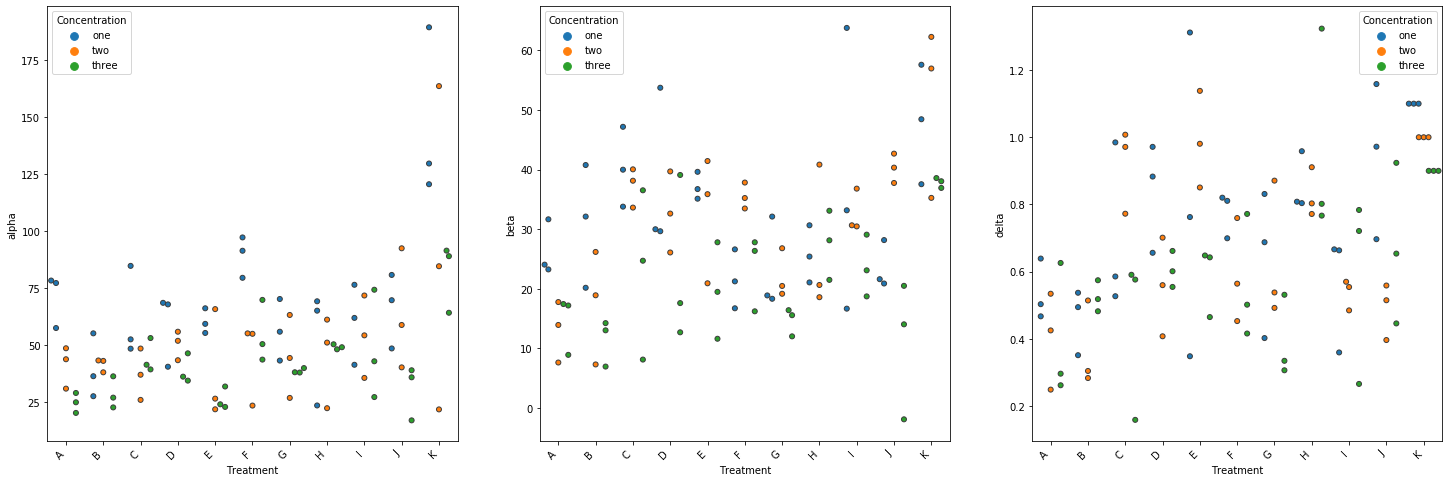

In [33]:
# Dotplot of all three Condition columns and all Treatments for side-by-side comparison
fig, ax = plt.subplots(1,3, sharey=False, figsize=(25,8))
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

a = sns.swarmplot(data=data, x='Treatment', y='alpha', hue='Concentration', linewidth=1, ax=ax[0],dodge=True)
b = sns.swarmplot(data=data, x='Treatment', y='beta', hue='Concentration', linewidth=1, ax=ax[1],dodge=True)
c = sns.swarmplot(data=data, x='Treatment', y='delta', hue='Concentration', linewidth=1, ax=ax[2],dodge=True)

## PCA plot

Explained variance ratio: [0.54881302 0.23333222 0.21785476]


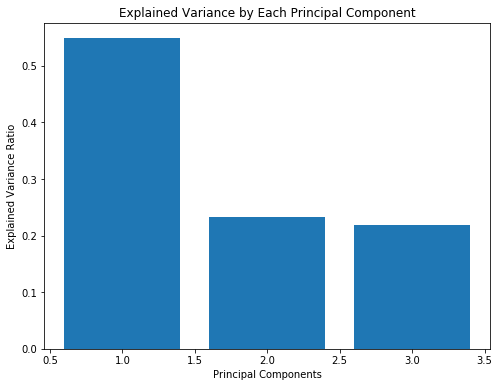

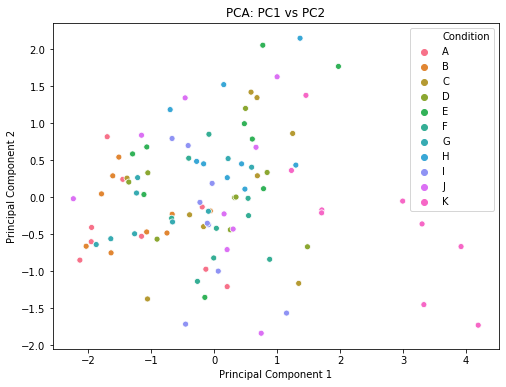

In [34]:
# Uses the data df as input.
# Outputs a PCA plot with information on variance & PCA plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select only the numeric columns for PCA (columns 4, 5, and 6).
df_measurements = data.iloc[:, 3:6]

# Standardize the measurements to have zero mean and unit variance
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_measurements)

# Perform PCA on the standardized data
pca = PCA()
pca.fit(df_standardized)

# Explained variance ratio (how much variance each principal component explains)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the explained variance for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.show()

# Transform the data into the principal components
df_pca = pca.transform(df_standardized)

# Create a DataFrame of the PCA results (principal component scores)
df_pca_results = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

# Add condition descriptions and replicates back to the PCA results
df_pca_results['Condition'] = data.iloc[:, 0]  # First column (condition descriptions)
df_pca_results['Replicate'] = data.iloc[:, 2]  # Third column (replicates)

# Visualize the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca_results['PC1'], y=df_pca_results['PC2'], hue=df_pca_results['Condition'])
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()